In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [63]:
# load the data 
df = pd.read_csv('Data/engines2_data_cleaned_no_outliers.csv')

In [64]:
# Ensure df is a DataFrame
if isinstance(df, pd.DataFrame):
	# select the relevant columns
	X = df[['flight_cycle', 'flight_phase', 'egt_probe_average', 'fuel_flw', 'core_spd', 'zpn12p', 'vib_n1_#1_bearing', 'vib_n2_#1_bearing', 'vib_n2_turbine_frame']].copy()
else:
	raise TypeError("The variable 'df' is not a DataFrame. Please ensure it is properly defined.")
Y= df['RUL'].copy()

In [65]:
# getdummy for eng_number
X = pd.get_dummies(X, columns=['flight_phase'], drop_first=False)

In [88]:
X.columns

Index(['flight_cycle', 'egt_probe_average', 'fuel_flw', 'core_spd', 'zpn12p',
       'vib_n1_#1_bearing', 'vib_n2_#1_bearing', 'vib_n2_turbine_frame',
       'flight_phase_CLIMB', 'flight_phase_CRUISE', 'flight_phase_TAKEOFF'],
      dtype='object')

In [66]:
# find min and max values for each column
min_values = X.min()
max_values = X.max()
# print min and max values
print("Minimum values:\n", min_values)
print("\nMaximum values:\n", max_values)


Minimum values:
 flight_cycle                   0
egt_probe_average       610.3875
fuel_flw                  1118.0
core_spd                   92.12
zpn12p                     56.54
vib_n1_#1_bearing            0.0
vib_n2_#1_bearing            0.0
vib_n2_turbine_frame         0.0
flight_phase_CLIMB         False
flight_phase_CRUISE        False
flight_phase_TAKEOFF       False
dtype: object

Maximum values:
 flight_cycle              4690
egt_probe_average        951.7
fuel_flw                5687.0
core_spd                108.68
zpn12p                   91.08
vib_n1_#1_bearing       0.3533
vib_n2_#1_bearing        1.075
vib_n2_turbine_frame     1.625
flight_phase_CLIMB        True
flight_phase_CRUISE       True
flight_phase_TAKEOFF      True
dtype: object


In [67]:
# use pycaret regression to compare models
from pycaret.regression import *

s = setup(data=pd.concat([X, Y], axis=1), target='RUL', session_id=42)

# Compare models
best = compare_models()


,Description,Value
0,Session id,42
1,Target,RUL
2,Target type,Regression
3,Original data shape,"(84169, 12)"
4,Transformed data shape,"(84169, 12)"
5,Transformed train set shape,"(58918, 12)"
6,Transformed test set shape,"(25251, 12)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,109.5706,24373.0202,156.1109,0.9840,0.2134,0.1506,2.4820
rf,Random Forest Regressor,111.8856,25675.7373,160.2254,0.9831,0.2193,0.1539,4.3240
xgboost,Extreme Gradient Boosting,126.4928,27878.2033,166.9620,0.9817,0.2615,0.1897,0.2360
lightgbm,Light Gradient Boosting Machine,139.9071,31411.8878,177.2276,0.9793,0.2777,0.2347,0.1770
gbr,Gradient Boosting Regressor,175.4139,43118.2009,207.6424,0.9716,0.3207,0.2949,1.1440
dt,Decision Tree Regressor,123.0458,53821.7618,231.9792,0.9646,0.2918,0.1630,0.1020
lar,Least Angle Regression,228.5600,63452.9565,251.8964,0.9583,0.4414,0.3967,0.0320
br,Bayesian Ridge,228.6003,63453.0731,251.8967,0.9583,0.4413,0.3967,0.0370
ridge,Ridge Regression,228.5708,63452.9546,251.8964,0.9583,0.4414,0.3967,0.0370
lr,Linear Regression,228.5600,63452.9565,251.8964,0.9583,0.4414,0.3967,1.1810


In [68]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [69]:
# Initial 80/20 split
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
# Further split temp into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Check the shapes of the splits
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (67335, 11), y_train shape: (67335,)
X_val shape: (8417, 11), y_val shape: (8417,)
X_test shape: (8417, 11), y_test shape: (8417,)


In [70]:
X_train.head()

,flight_cycle,egt_probe_average,fuel_flw,core_spd,zpn12p,vib_n1_#1_bearing,vib_n2_#1_bearing,vib_n2_turbine_frame,flight_phase_CLIMB,flight_phase_CRUISE,flight_phase_TAKEOFF
40668,0.155224,0.428200,0.219085,0.563406,0.785177,0.207472,0.209302,0.107692,0.0,1.0,0.0
76442,0.337313,0.767185,0.850514,0.835749,0.917487,0.660345,0.395349,0.292308,1.0,0.0,0.0
8489,0.615778,0.405457,0.262421,0.467995,0.773596,0.603736,0.139535,0.569231,0.0,1.0,0.0
68074,0.557569,0.409412,0.245568,0.494565,0.753040,0.169827,0.395349,0.661538,0.0,1.0,0.0
52608,0.238166,0.696979,0.455898,0.703502,0.784598,0.207472,0.162791,0.630769,0.0,0.0,1.0


🧠 Multiple Models for Comparison   
train top 3 models Extra Trees Regressor, Random Forest Regressor, and Gradient Boosting Regressor

In [71]:
# Random Forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# model training with Random Forest and cross-validation for hyperparameter tuning

param_grid = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [20],
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best Parameters: {'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [72]:
# Evaluate the model on the validation set
y_val_pred = best_rf.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")
r2_val = best_rf.score(X_val, y_val)
print(f"Validation R^2: {r2_val}")

Validation MAE: 130.5421489399158, Validation RMSE: 173.48064302827837
Validation R^2: 0.9802111363532775


In [73]:
# Evaluate the model on the test set
y_test_pred = best_rf.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}")
r2_test = best_rf.score(X_test, y_test)
print(f"Test R^2: {r2_test}")


Test MAE: 131.67974846810344, Test RMSE: 174.00846869574167
Test R^2: 0.9797750626370519


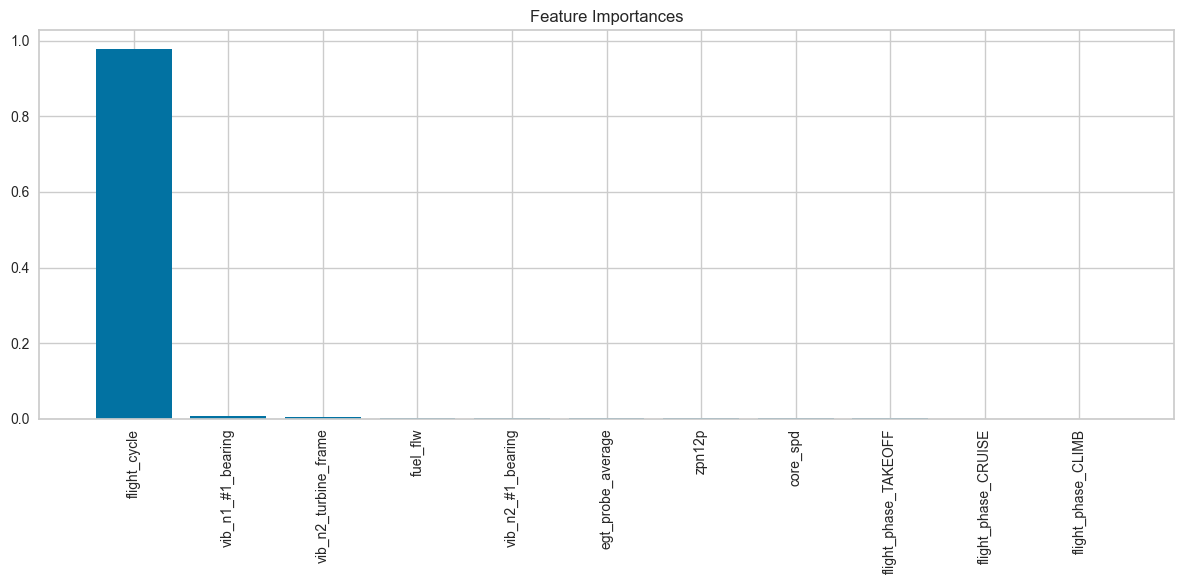

In [74]:
# Feature Importance
importances = best_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()


In [75]:
# save the model
import joblib
import pickle
joblib.dump(best_rf, 'best_rf_model.pkl',protocol=pickle.HIGHEST_PROTOCOL, compress=4)
# save the scaler
joblib.dump(scaler, 'scaler_rf.pkl')

['scaler_rf.pkl']

In [76]:
# Try XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# use the most influencing hyperparameters for XGBoost
# n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree

param_grid = {
    'n_estimators': [300],
    'reg_alpha': [0],  # L1 regularization
    'reg_lambda': [10]      # L2 regularization
}

#make sure that the model generalize well
# use cross-validation to find the best hyperparameters

xgb_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best Parameters: {'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 10}


In [77]:
# Evaluate the model on the validation set
y_val_pred = best_xgb.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)    
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")
r2_val = r2_score(y_val, y_val_pred)
print(f"Validation R^2: {r2_val}")



Validation MAE: 115.33053552814062, Validation RMSE: 156.54498592572793
Validation R^2: 0.9838862310056824


In [78]:
# Evaluate the model on the test set
y_test_pred = best_xgb.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}")
r2_test = r2_score(y_test, y_test_pred)
print(f"Test R^2: {r2_test}")


Test MAE: 118.0025428484692, Test RMSE: 158.24292961512694
Test R^2: 0.9832738863217547


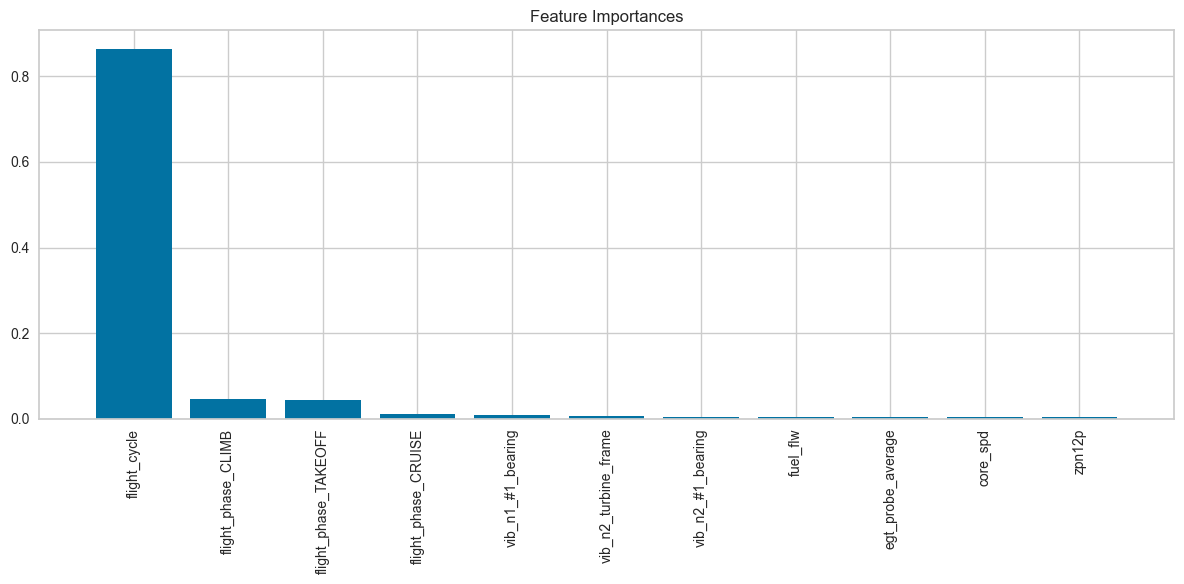

In [79]:
# Feature Importance
importances = best_xgb.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.savefig('feature_importances_xgb.png')
plt.show()

In [80]:
# Save the model
import joblib
joblib.dump(best_xgb, 'best_xgb_model.pkl')
# Save the scaler
joblib.dump(scaler, 'scale_xgb.pkl')

['scale_xgb.pkl']

In [81]:
# Try Extra Trees Regressor
from sklearn.ensemble import ExtraTreesRegressor

# use the most influencing hyperparameters for extra trees
# n_estimators, max_depth, min_samples_split, min_samples_leaf

param_grid = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [20]}

#make sure that the model generalize well
# use cross-validation to find the best hyperparameters

etr = ExtraTreesRegressor(random_state=42)
grid_search = GridSearchCV(etr, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_etr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [82]:
# Evaluate the model on the validation set
y_val_pred = best_etr.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")
r2_val = r2_score(y_val, y_val_pred)
print(f"Validation R^2: {r2_val}")


Validation MAE: 145.32302458959325, Validation RMSE: 179.01739014735344
Validation R^2: 0.9789278304382829


In [83]:
# Evaluate the model on the test set
y_test_pred = best_etr.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}")
r2_test = r2_score(y_test, y_test_pred)
print(f"Test R^2: {r2_test}")


Test MAE: 146.44268825704987, Test RMSE: 180.06982328326484
Test R^2: 0.9783415041790828


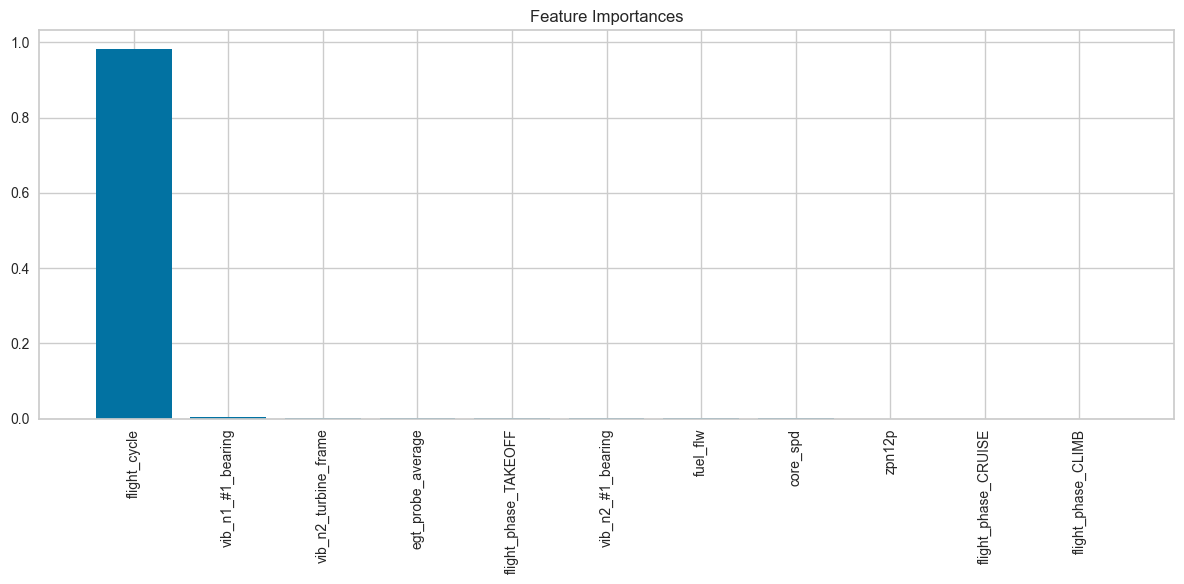

In [84]:
#feaeture importance
importances = best_etr.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.savefig('feature_importances_etr.png')
plt.show()

In [85]:
# Save the model
import joblib
joblib.dump(best_etr, 'best_etr_model.pkl', protocol=pickle.HIGHEST_PROTOCOL,compress=4)
# Save the scaler
joblib.dump(scaler, 'scale_etr.pkl')


['scale_etr.pkl']